<a href="https://colab.research.google.com/github/cosmina98/PhD/blob/main/MLP_Wrapped_update/Wrapped_up_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
!pip install torchmetrics --quiet

In [3]:

!pip install -U scikit-learn --user



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.anaconda.org/scipy-wheels-nightly/simple


In [183]:
# libary imports 
import os
import torch
from torch import nn
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm

import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import time
import pandas as pd

import itertools
from functools import reduce
import operator
import torch.utils.data as data_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from torch.utils.data import Subset

from torch.optim.adadelta import Adadelta
from torch.optim.adagrad import Adagrad
from torch.optim.adam import Adam
from torch.optim.adamax import Adamax
from torch.optim.adamw import AdamW
from torch.optim.optimizer import Optimizer
from torch.optim.sgd import SGD



plt.rcParams['figure.figsize'] = [5, 5]

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Main program

In [185]:
def get_classification_report(y, y_pred):
       # y_prime = np.stack([np.stack([d for d in d_]) for d_ in y]).flatten()
       # y_pred_prime=np.stack([np.stack([d for d in d_]) for d_ in y_pred]).flatten()   
        print(classification_report(y, y_pred))


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def get_confusion_matrix(y, y_pred, plot=True):
      #y_prime = np.stack([np.stack([d for d in d_]) for d_ in y]).flatten()
      #y_pred_prime=np.stack([np.stack([d for d in d_]) for d_ in y_pred]).flatten()
      cnf_matrix = confusion_matrix(y, y_pred,labels=np.arange(10))
      np.set_printoptions(precision=2)
      #print(cnf_matrix)
      # Plot non-normalized confusion matrix
      if plot==True:
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=np.arange(len(torch.unique(torch.tensor(y_pred)))),
                              title='Confusion matrix, without normalization')
          

In [138]:


# Prepare CIFAR-10 dataset
trainset = CIFAR10(os.getcwd(), download=True, transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

testset = CIFAR10(os.getcwd(), download=True, transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))


#print(images, labels)

def my_fun(dataset):
    X=[]
    y=[]
    for feature, label in iter(dataset):
        X.append(feature)
        y.append(label)
    return torch.stack(X).numpy(), y


#get  data as numpy arrays
X_train, y_train = my_fun(trainset)
X_test, y_test =my_fun(testset)


Files already downloaded and verified
Files already downloaded and verified


In [139]:
class MLPClassifer(nn.Module):
      '''
        Multilayer Perceptron.
      '''
      def __init__(
        self,
        input_dim,
        output_dim,
        first_hidden_dimension=64,
        #if you only want to add  a single hidden layer you do the following:
       # hidden_layers=((32),)
        hidden_layers=((32),),
        ):
        super().__init__()
        #self.modules1 = torch.nn.ModuleList([])
        self.residual=False
        self.hidden_layer_num=len(hidden_layers)
        self.d_in=input_dim
        if self.hidden_layer_num>0:
            self.h_0=first_hidden_dimension
            self.h_n=hidden_layers[-1]
 
        else: 
            self.h_0=self.h_n=first_hidden_dimension
      

        self.linear1=nn.Linear(self.d_in,  self.h_0)
        self.relu=torch.nn.ReLU()
        self.hidden_linear=[]
        if self.hidden_layer_num>0:
          in_channels=self.h_0
          for h_dim in list(hidden_layers):
              #self.modules1.append(nn.Linear(in_channels, in_channels))
              self.hidden_linear.append(torch.nn.Linear(in_channels, h_dim))
              in_channels = h_dim
        self.hidden_linear=nn.ModuleList(self.hidden_linear)
        self.linear2=nn.Linear( self.h_n, output_dim)
        #self.modules1.append(nn.Linear( self.h_n, output_dim))

    
      def forward(self, x):
        x=x.view(-1,self.d_in)
        x=self.linear1(x)
        x=self.relu(x)
        if self.hidden_layer_num>0:
          for linear in self.hidden_linear:
            if self.residual:
              x=self.relu(linear(x)) + x
          else:
              x = self.relu(linear(x))
        return  F.log_softmax(self.linear2(x), dim=1)

In [140]:
class Optimiser(object):
    def __init__(self,name='Adam',classifier=MLPClassifer(input_dim=len(X_train),output_dim=len(np.unique(y_train))),learning_rate=1e-3,  betas=(0.9,0.99) , eps=1e-8, weight_decay=0, amsgrad=False,
      momentum=0.9, nesterov=True, dampening=0, maximize=False,
      rho=0.9,lr_decay=0,initial_accumulator_value=0,capturable=False,
       max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, history_size=100, line_search_fn=None,
       lambd=0.0001, alpha=0.75, t0=1000000.0, momentum_decay=0.004,centered=False,
       etas=(0.5, 1.2), step_sizes=(1e-06, 50)):
          self.learning_rate=learning_rate 
          self.betas= betas
          self.eps= eps
          self.weight_decay=weight_decay
          self.amsgrad=amsgrad 
          self.momentum=momentum
          self.nesterov=nesterov
          self.dampening=dampening
          self.maximize=maximize
          self.classifier=classifier
          self.name=name
          self.optimiser=self.set_optimizer(self.name)
          self.rho=rho
          self.lr_decay=lr_decay
          self.capturable=capturable

          #lbfgs
          self.max_iter=max_iter
          self.max_eval=max_eval
          self.tolerance_grad=tolerance_grad
          self.tolerance_change=tolerance_change
          self.history_size=history_size
          self.line_search_fn=line_search_fn

          #asgd
          self.lambd=lambd
          self.alpha=alpha
          self.t0=t0
          
          #Nadam
          self.momentum_decay=momentum_decay

          self.centered=centered
          self.etas=etas
          self.step_sizes=step_sizes

    def set_optimizer(self, name):
            if name.lower().strip()=='adam':
                        self.optimiser=torch.optim.Adam(self.classifier.parameters(),lr=self.learning_rate, betas=self.betas, eps=self.eps, weight_decay=self.weight_decay, amsgrad=self.amsgrad,maximize=self.maximize)
            elif name.lower().strip()=='sgd':
                        self.optimiser=torch.optim.SGD(self.classifier.parameters(),lr=self.learning_rate, weight_decay=self.weight_decay, momentum=0.9,nesterov=self.nesterov , dampening=self.dampening,maximize=self.maximize)
            elif name.lower().strip()=='adadelta':
                        self.optimiser=torch.optim.Adadelta(self.classifier.parameters(),lr=self.learning_rate, weight_decay=self.weight_decay, eps=self.eps, rho=self.rho,maximize=self.maximize)
            elif name.lower().strip()=='adagrad':
                        self.optimiser=torch.optim.Adagrad(self.classifier.parameters(),lr=self.learning_rate, eps=self.eps, weight_decay=self.weight_decay, maximize=self.maximize,lr_decay=self.lr_decay, initial_accumulator_value=self.initial_accumulator_value)
            elif name.lower().strip()=='adamw':
                        self.optimiser=torch.optim.AdamW(self.classifier.parameters(),lr=self.learning_rate, betas=self.betas, eps=self.eps, weight_decay=self.weight_decay, amsgrad=self.amsgrad,maximize=self.maximize, capturable=self.capturable)
            elif name.lower().strip()=='adamax':
                        self.optimiser=torch.optim.Adamax(self.classifier.parameters(),lr=self.learning_rate, betas=self.betas, eps=self.eps, weight_decay=self.weight_decay,maximize=self.maximize)
            elif name.lower().strip()=='lbfgs':
                        self.optimiser=torch.optim.LBFGS(self.classifier.parameters(),lr=self.learning_rate, max_iter=self.max_iter,max_eval=self.max_eval, tolerance_grad=self.tolerance_grad,tolerance_change=self.tolerance_change, history_size=self.history_size,line_search_fn=self.line_search_fn)
            elif name.lower().strip()=='asgd':
                        self.optimiser=torch.optim.ASGD(self.classifier.parameters(),lr=self.learning_rate, weight_decay=self.weight_decay, lambd=self.lambd, alpha=self.alpha, t0=self.t0 )
            elif name.lower().strip()=='nadam':
                        self.optimiser=torch.optim.NAdam(self.classifier.parameters(),lr=self.learning_rate, weight_decay=self.weight_decay, eps=self.eps, betas=self.betas, momentum_decay=self.momentum_decay)
            elif name.lower().strip()=='radam':
                        self.optimiser=torch.optim.RAdam(self.classifier.parameters(),lr=self.learning_rate, weight_decay=self.weight_decay, eps=self.eps, betas=self.betas )
            elif name.lower().strip()=='rmsprop':
                        self.optimiser=torch.optim.RMSprop(self.classifier.parameters(),lr=self.learning_rate, weight_decay=self.weight_decay, momentum=self.momentum,alpha=self.alpha, eps=self.eps, centered=self.centered)
            elif name.lower().strip()=='rprop':
                        self.optimiser=torch.optim.Rprop(self.classifier.parameters(),lr=self.learning_rate, etas=self.etas, step_sizes=self.step_sizes)
            
            return self.optimiser


In [155]:


class Neural_Network(object):
    
    
    def __init__ (self,batch_size=2000,epochs=2,verbose=True,loss_function = nn.CrossEntropyLoss(),
         optimiser_name='adam',classifier= MLPClassifer(input_dim=len(X_train),output_dim=len(np.unique(y_train)))):
      
      self.batch_size=batch_size
      self.epochs=epochs
      
      self.verbose=True
      #used inside the training/ testing loops
      self.running_loss = 0
      self.loss_function = loss_function
      self.classifier= classifier
      
      self.sm = torch.nn.Softmax()

      #default optimiser: adam 
      self.optimiser=Optimiser(optimiser_name,classifier=self.classifier).optimiser
    
    
    def get_params(self): #get parameters
       if (self.optimiser != None) :
         return  (self.props(),self.optimiser.state_dict(), self.classifier.state_dict)
       else: return self.classifier.state_dict() 
  
    def fit(self,X,y):
        train = [*zip(X,y)]
        trainloader =  torch.utils.data.DataLoader(train,batch_size=8, shuffle=False, num_workers=2)
        for epoch in range(self.epochs):  # loop over the dataset 2 times
        
          running_loss =self.running_loss
          for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
             
            # zero the parameter gradients
            self.optimiser.zero_grad()

            # forward + compute loss+ backward + optimize
            outputs = self.classifier(inputs)
            #print(outputs)
            loss = self.loss_function(outputs, labels)
            loss.backward()
            self.optimiser.step()
            # print statistics
            running_loss += loss.item()
            if i % self.batch_size == (self.batch_size-1):    # print every "batch_size" mini-batches
                if self.verbose==True:
                  print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / self.batch_size:.3f}')
                running_loss = 0.0

    def predict(self, X_test): #Predict using the multi-layer perceptron classifier.

      if isinstance(X_test, (pd.Series, list, np.ndarray)):
        X_test=(torch.tensor(X_test,  requires_grad = False))
        outputs = self.classifier(X_test)
        log_prob, predictions = torch.max(outputs, 1)
        return predictions #torch.stack(prediction_list)
      else:
        with torch.no_grad():
          outputs = self.classifier(X_test)
          log_prob, predictions = torch.max(outputs, 1)
          return predictions #torch.stack(prediction_list)


    def predict_log_proba(self,X):  #	Return the log of probability estimates.
        y_prob=(self.predict_proba(X))
        log_proba=np.log(y_prob.detach().numpy())
        return log_proba
 

    def predict_proba(self,X_test):	#Probability estimates.
      probabilities_list=[]
      if isinstance(X_test, (pd.Series, list, np.ndarray)):
        X_test=(torch.tensor(X_test,  requires_grad = False))
        outputs = self.classifier(X_test)
        estimation, predictions = torch.max(outputs, 1)
        predicted=self.sm( outputs) 
        return predicted
      else:
        with torch.no_grad():
            outputs = self.classifier(X_test)
            predicted=self.sm( outputs) 
            return  predicted

    def score(self,X_test,y_test): #Return the mean accuracy on the given test data and labels.
        return accuracy_score(y_test, self.predict(X_test).numpy(), sample_weight=None)
        
    def score_per_class(self,X_test,y_test):
      
      if isinstance(X_test, (pd.Series, list, np.ndarray)):
        num_classes=len(torch.unique(torch.tensor(y_test)))
      else:
        num_classes=len(torch.unique((y_test)))
       #Return the mean accuracy on the given test data and labels.
      classes=tuple(np.arange(num_classes)) 
      correct_pred = {classname: 0 for classname in np.arange(num_classes)}
      total_pred= {classname: 0 for classname in np.arange(num_classes)}
      predictions= self.predict(X_test).numpy()
      for label, prediction in zip(y_test, predictions):
          if label == prediction:
              correct_pred[classes[label]] += 1
          total_pred[classes[label]] += 1
          accuracies={}
        # print accuracy for each class
      for classname, correct_count in correct_pred.items():
          accuracy = 100 * float(correct_count) / total_pred[classname]
          accuracies[classname]=accuracy
          if self.verbose:
            print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

        

    def set_params(self, attr, value): #sets parameters
        setattr(self, attr, value)
        
    def props(cls):   
        return [i for i in cls.__dict__.items() if i[:1] != '_']

    def get_classifier(self):
        return self.classifier()


    


In [158]:
model=Neural_Network()
model.classifier=MLPClassifer(input_dim=reduce(operator.mul,trainset.data[1].shape), output_dim=len(torch.unique(torch.tensor(trainset.targets)))) 
model.optimiser=Optimiser('adam', model.classifier, learning_rate=1e-4).optimiser
model.loss_function = nn.CrossEntropyLoss()
model.fit(X_train , y_train)
print("Overall Accuracy", model.score(X_test, y_test))

[1,  2000] loss: 1.933
[1,  4000] loss: 1.701
[1,  6000] loss: 1.657
[2,  2000] loss: 1.587
[2,  4000] loss: 1.537
[2,  6000] loss: 1.541
Overall Accuracy 0.47848


In [159]:
model.score_per_class(X_test, y_test)

Accuracy for class: 0 is 45.9 %
Accuracy for class: 1 is 63.2 %
Accuracy for class: 2 is 24.7 %
Accuracy for class: 3 is 38.4 %
Accuracy for class: 4 is 32.4 %
Accuracy for class: 5 is 37.9 %
Accuracy for class: 6 is 58.7 %
Accuracy for class: 7 is 58.9 %
Accuracy for class: 8 is 65.4 %
Accuracy for class: 9 is 53.0 %


In [169]:
y_pred= (model.predict(X_test).numpy())

In [166]:
get_classification_report(y_test, (model.predict(X_test).numpy()))
  

              precision    recall  f1-score   support

           0       0.58      0.46      0.51      5000
           1       0.52      0.63      0.57      5000
           2       0.44      0.25      0.32      5000
           3       0.34      0.38      0.36      5000
           4       0.46      0.32      0.38      5000
           5       0.39      0.38      0.39      5000
           6       0.44      0.59      0.51      5000
           7       0.52      0.59      0.55      5000
           8       0.56      0.65      0.60      5000
           9       0.53      0.53      0.53      5000

    accuracy                           0.48     50000
   macro avg       0.48      0.48      0.47     50000
weighted avg       0.48      0.48      0.47     50000



Confusion matrix, without normalization


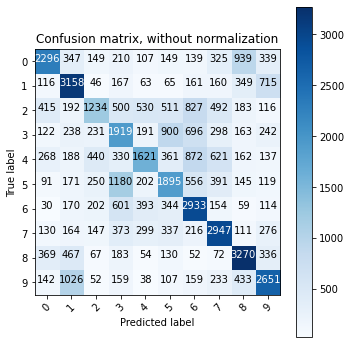

In [186]:
get_confusion_matrix(y_test, y_pred, plot=True)

In [188]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[43317,  1683],
        [ 2704,  2296]],

       [[42037,  2963],
        [ 1842,  3158]],

       [[43416,  1584],
        [ 3766,  1234]],

       [[41297,  3703],
        [ 3081,  1919]],

       [[43123,  1877],
        [ 3379,  1621]],

       [[42096,  2904],
        [ 3105,  1895]],

       [[41322,  3678],
        [ 2067,  2933]],

       [[42254,  2746],
        [ 2053,  2947]],

       [[42456,  2544],
        [ 1730,  3270]],

       [[42606,  2394],
        [ 2349,  2651]]])

#Plot classifier comparaison



In [ ]:
!pip install --upgrade scikit-learn

!pip install scipy

!pip3 install -U scikit-learn scipy matplotlib

In [ ]:
!pip install  scikit-learn==1.0.1



In [189]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

ImportError: ignored